# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Проанализируем данные, подоберем для них оптимальную прогнозирующую модель в классе ARIMA и построим прогноз на каждый месяц на два года вперёд от конца данных. Затем, сравним полученные значения с реальными.

In [45]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
%pylab inline

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [46]:
#Считываем данные
wage = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Text(0.5, 1.0, 'Average salary in Russia per month')

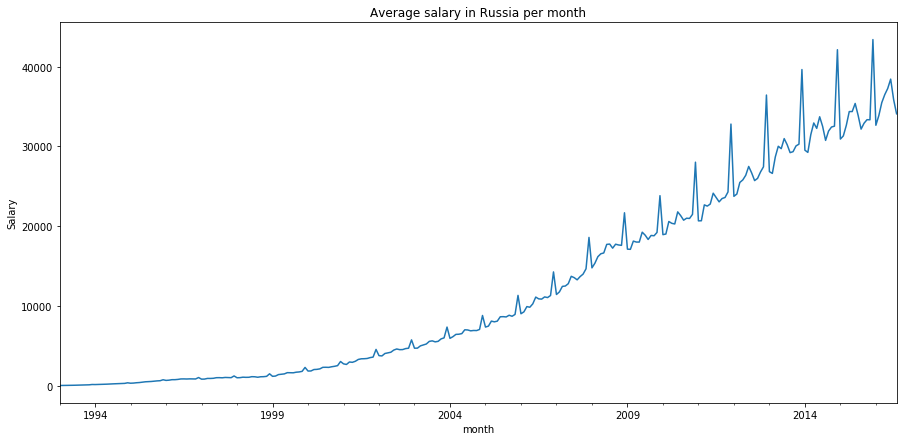

In [47]:
#График средней зарплаты
plt.figure(figsize = (15,7))
wage.WAG_C_M.plot()
plt.ylabel('Salary')
plt.title('Average salary in Russia per month')

Что можно сказать про этот ряд? У него выраженная сезоность (в декабре многим выплачиваются премии), кроме того имеется некоторый нелинейный и положительный тренд. У ряда нестационарная дисперсия.

Визуально, видно, что ряд нестационарен. Однако проверим наше предположение с помощью критерия Дики-Фуллера.

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

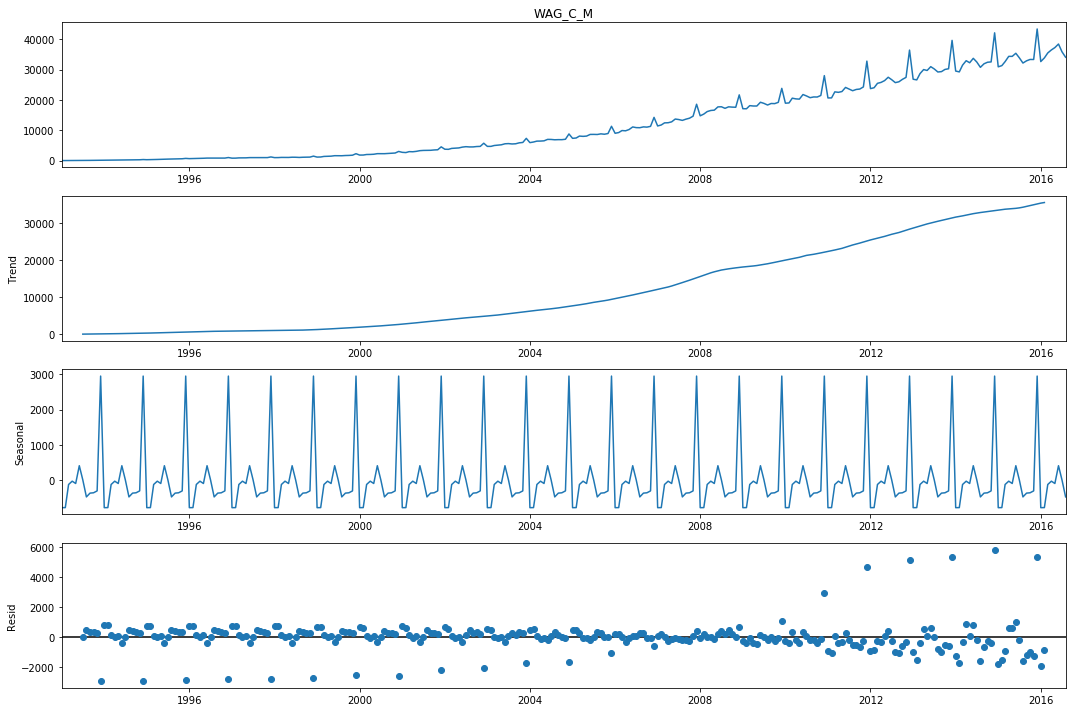

In [48]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

Критерий Дики-Фуллера дает достигаемый уровень значимости в **p-value=0.991850**, что говорит о том, что мы не можем отвергнуть гипотезу о нестационарности ряда. Как было сказано выше, мы видим сезонность и тренд.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


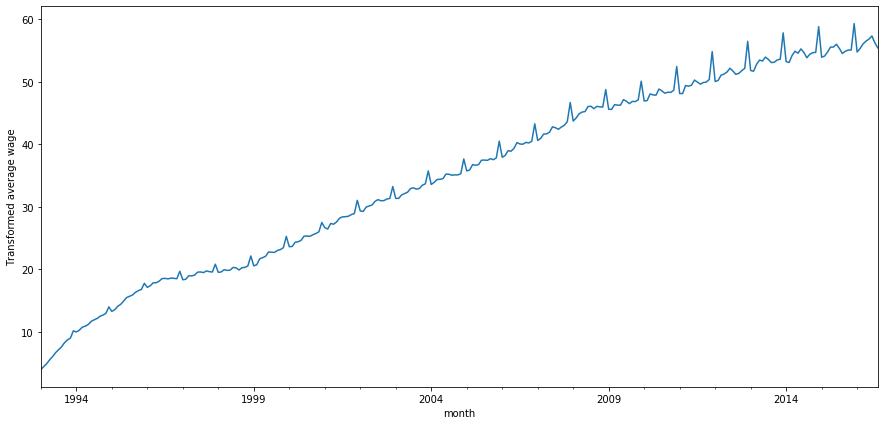

In [60]:
wage['wage_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.wage_box.plot()
plt.ylabel(u'Transformed average wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1])

Достигаемый уровень значимости понизился, но всё ещё не можем отвергнуть гипотезу.

### Дифференцирование

В данных наблюдался тренд. Попробуем от него избавиться путем сезонного дифференцирования, а затем проверим ряд снова на стационарность.

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

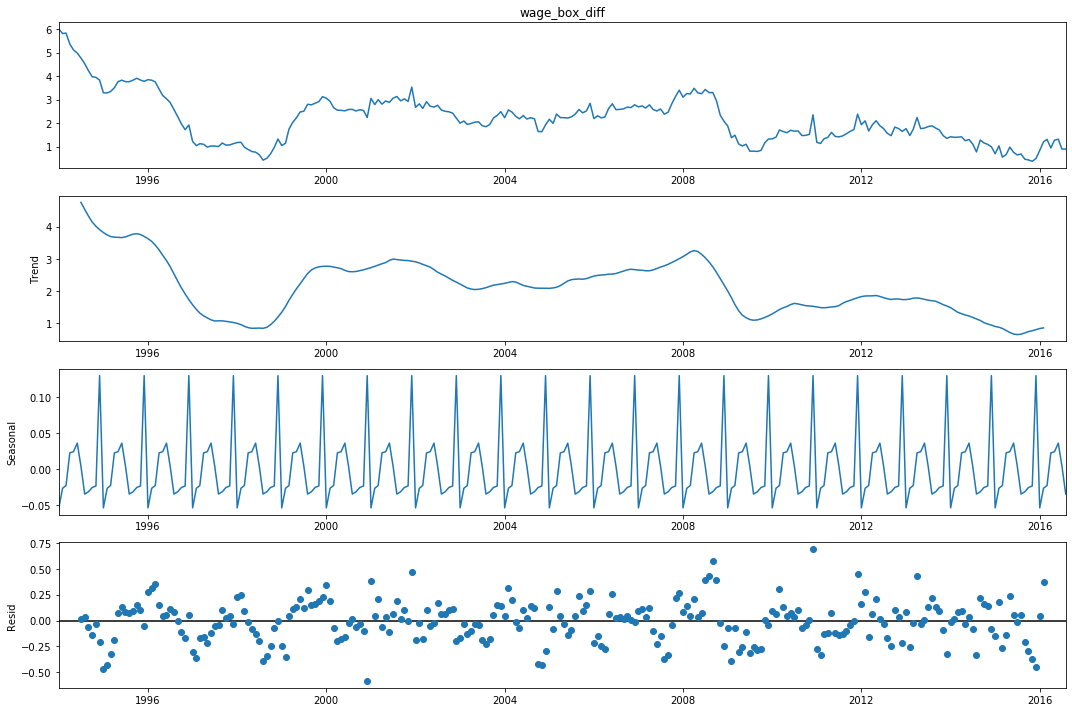

In [50]:
wage['wage_box_diff'] = wage.wage_box - wage.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff[12:])[1])

Тренд визуально наблюдается, хотя критерий Дики-Фуллера и отвергает гипотезу о нестационарности. Попробуем добавить еще и обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

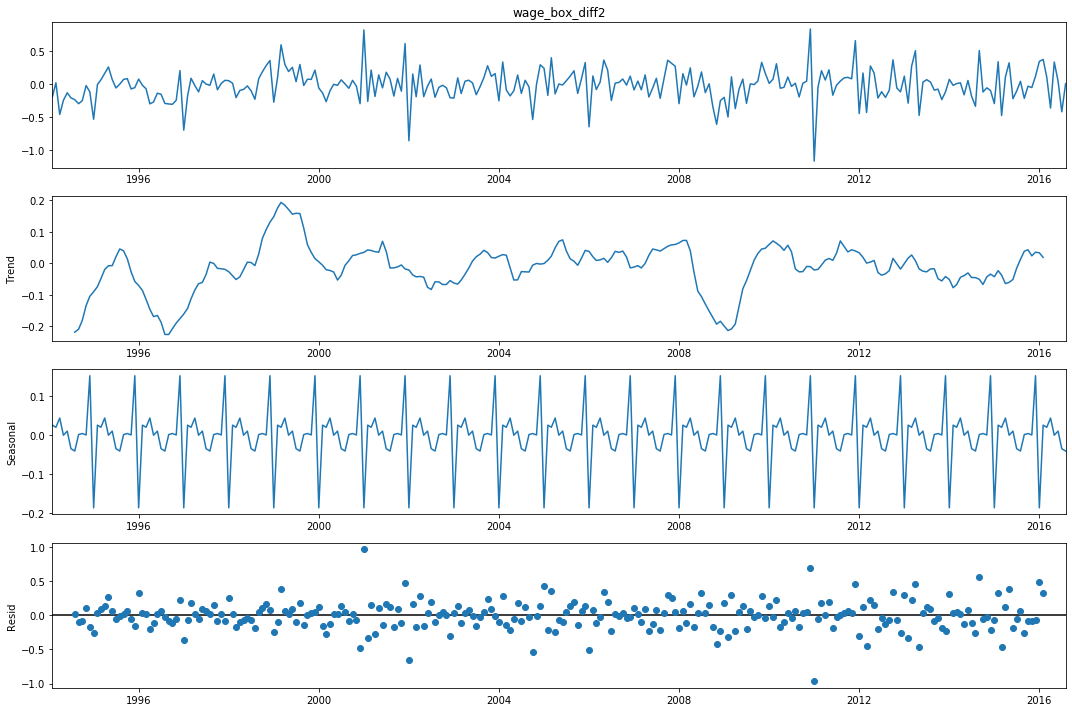

In [51]:
wage['wage_box_diff2'] = wage.wage_box_diff - wage.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff2[13:])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности, кроме того мы видим, что ряд стационарен.

### Выбор начальных приближений для p, q, P, Q

Так ряд у нас теперь стационарен, то мы можем подбирать параметры для прогнозирования с помощью модели SARIMAX.

Для этого проанализируем графики автокорреляционной функции и частичной автокорреляции.

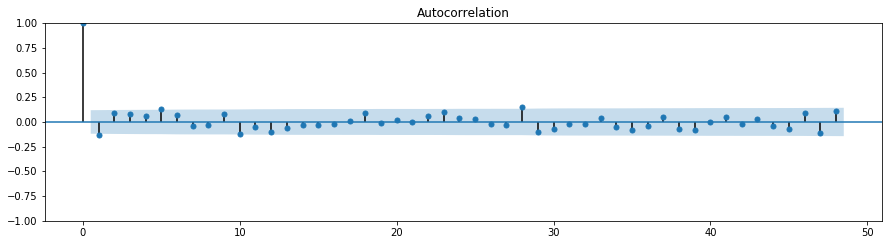

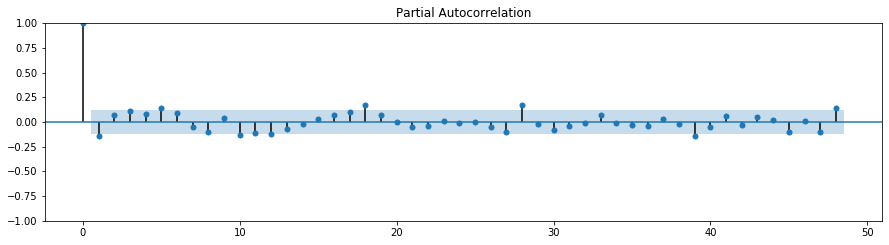

In [52]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: q = 1, Q = 0, p = 1, P = 4 (S = 12, из условия задачи)

In [53]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [54]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [55]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

CPU times: user 14.8 s, sys: 735 ms, total: 15.5 s
Wall time: 8.94 s


Посмотрим на лучшие параметры (отбор проводился с помощью информационного критерия Акаике)

In [56]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
11  (1, 0, 1, 0)  0.340521
6   (0, 1, 1, 0)  1.170768
12  (1, 0, 2, 0)  1.622924
16  (1, 1, 1, 0)  2.021911
7   (0, 1, 2, 0)  2.509650


Итого: лучшая модель

In [57]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 03 Oct 2021   AIC                              0.341
Time:                                    14:11:16   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


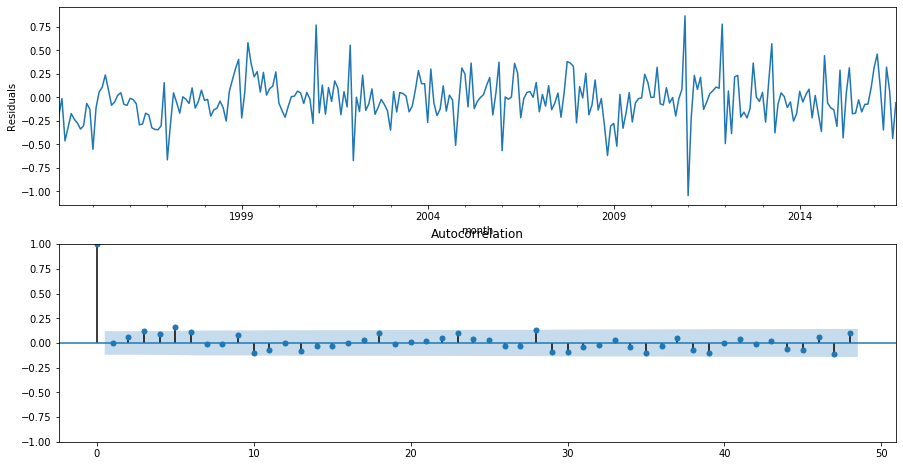

In [58]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

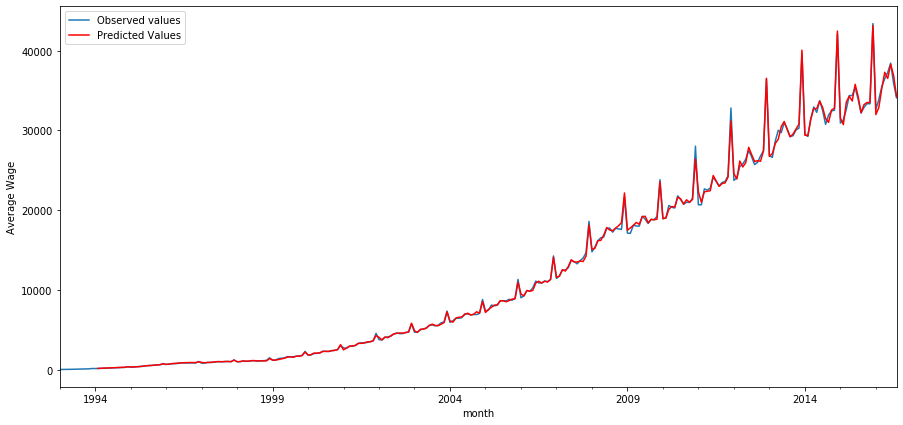

In [66]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot(label = 'Observed values')
wage.model[13:].plot(color='r', label='Predicted Values')
plt.ylabel('Average Wage')
plt.legend()
pylab.show()

Модель хорошо описывает наши данные

### Прогноз

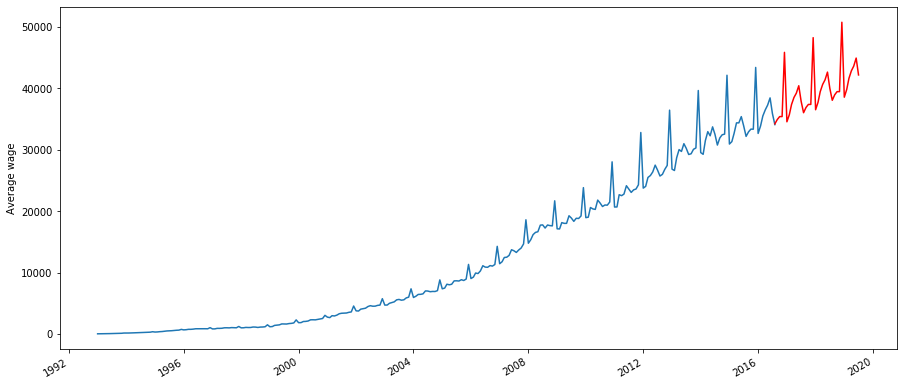

In [67]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot(label='Observed values')
wage2.forecast.plot(color='r', label='Forecast')
plt.ylabel('Average wage')
pylab.show()

А теперь сравним реальные данные (зарплаты с август 2016 по август 2019) с полученныем прогнозом.

In [85]:
real_wage = pd.read_csv('wages_real.csv', sep='\t', index_col=['month'], parse_dates=['month'], dayfirst=True)
real_wage.head()

,wage
month,
2016-08-01,35405
2016-09-01,35843
2016-10-01,35749
2016-11-01,36195
2016-12-01,47554


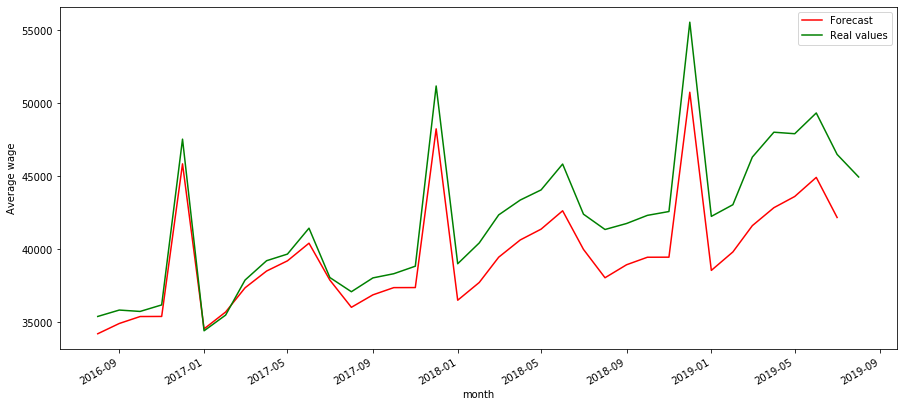

In [88]:
plt.figure(figsize(15,7))
wage2.forecast.plot(color='r', label='Forecast')
real_wage.wage.plot(color='g', label='Real values')
plt.ylabel('Average wage')
plt.legend()
pylab.show()

Предсказание не идеально, но по характеру совпадает.